# Adding Fibers data to FEB

Load main libraries, set paths and adjust plotting theme (optional)

In [1]:
from pathlib import Path
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')
pv.global_theme.background = 'white'
pv.global_theme.color = "beige"
pv.global_theme.show_edges = True
pv.global_theme.window_size = [800, 400]

STATICS_DIR = Path("../../../../_static")
HEXBEAM_MULTIBLOCK_FILEPATH = STATICS_DIR / "hex_ellipsoid_multiblock_fibers_case_1.vtm"

### Load the Mesh

In this examples, we are simply interested in manipulating the FEB file and not the mesh itself, therefore we will be used pre-defined mesh.
If you wish to create the mesh using python, we recommend using the pyvista or the gmsh and pygmsh libraries. 

In [2]:
mb = pv.read(HEXBEAM_MULTIBLOCK_FILEPATH)
mb

MultiBlock (0x2cbcfe44d60)
  N Blocks    2
  X Bounds    -0.380, 0.380
  Y Bounds    -0.380, 0.380
  Z Bounds    -0.800, 0.000

Extract each block from the multiblock

In [3]:
grid = mb["grid"]
selected_load_surface = mb["selected_load_surface"]

Extract the field data (just to make it easier later on)

In [4]:
grid_boundary_ids = grid.field_data["boundary_ids"]
load_surface_connectivity = selected_load_surface.field_data["load_surface_connectivity"]
fibers = grid["Fibers"]

Plot data

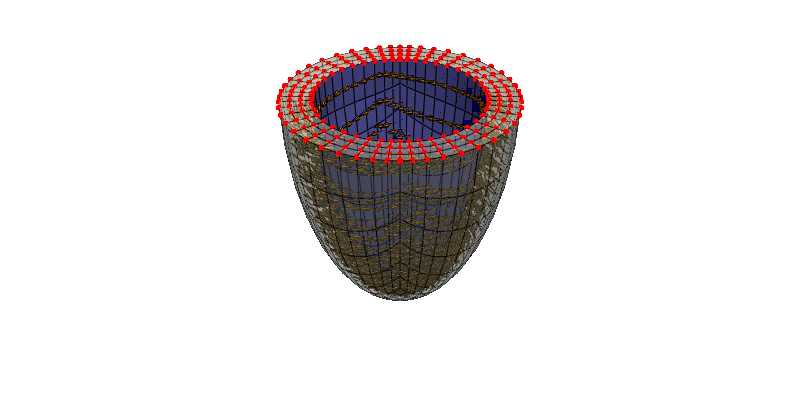

In [5]:
plotter = pv.Plotter()
plotter.add_mesh(grid, color="beige", opacity=0.5)
plotter.add_points(grid.points[grid_boundary_ids], color="red", point_size=6)
plotter.add_mesh(selected_load_surface, color="blue", point_size=6)
plotter.add_arrows(grid.cell_centers().points, fibers, mag=0.1, color="orange")
plotter.show()

### Create FEB

#### Create a FEB object:

In [6]:
from febio_python import Feb

feb = Feb(version=4.0)

#### Setup basic configurations:

In [7]:
feb.setup_module(module_type="solid") # default values
feb.setup_globals(T=0, R=0, Fc=0) # default values
feb.setup_controls(analysis="static") # here, you can change basic settings. See docs for more info.
feb.setup_output(variables=["displacement", "Lagrange strain", "stress", "fiber vector"])
# Note: added fiber vector for post-processing visualization (in FEBio); we can use febio-python to visualize it as well

qn_method {'attr_type': 'BFGS', 'max_ups': 10, 'max_buffer_size': 0, 'cycle_buffer': 1, 'cmax': 100000}


#### Add materials

In [8]:
from febio_python.core import Material

# Define the material
material_1 = Material(
    id=1,
    type="muscle material",
    name="FirstBlockMaterial",
    parameters={
        'g1': 500,
        'g2': 500,
        'p1': 0.05,
        'p2': 6.6,
        'smax': 3e5,
        'Lofl': 1.07,
        'k': 1e6,
        'fiber': {
            "_type": "vector"  # then data must be in MeshData format
        }
    }
)

Add the material to the FEB object

In [9]:
feb.add_materials([material_1])

#### Add mesh

In [10]:
from febio_python.core import Nodes, Elements

# Define the nodes
grid_nodes = Nodes(name="FirstBlockNodes", coordinates=grid.points)

# Define the elements
grid_elements = Elements(
    name="FirstBlockElements",
    type="HEXAHEDRON",
    connectivity=grid.cells_dict[pv.CellType.HEXAHEDRON],
    mat=1
)

Add the nodes and elements to the FEB object

In [11]:
feb.add_nodes([grid_nodes])
feb.add_elements([grid_elements])

#### Add Mesh Domains

In [12]:
from febio_python.core import SolidDomain

# create a shell domain
solid = SolidDomain(
    id=1,
    name="FirstBlockElements", # this must match one of the element names
    mat="FirstBlockMaterial", # this must match one of the material names
    )

feb.add_mesh_domains([solid])

#### Add Nodesets

In [13]:
from febio_python.core import NodeSet

# Define the node sets
boundary_nodeset = NodeSet(
    name="BoundaryNodes",
    ids=grid_boundary_ids
)

Add node sets to the FEB object

In [14]:
feb.add_node_sets([boundary_nodeset])

#### Add Boundary conditions

In [15]:
from febio_python.core import FixCondition
# create the fixed boundary condition
fixed = FixCondition(
    dof="x,y,z",  # fix only the z direction
    node_set="BoundaryNodes",
    name="Fixed")

Add the fixed boundary condition to the FEB object

In [16]:
feb.add_boundary_conditions([fixed])

#### Add Surfaces

In [17]:
from febio_python.core import Surfaces

# Define the surface
surface = Surfaces(
    name="LoadSurface",
    type="QUAD",
    connectivity=load_surface_connectivity,
)

Add surface to the FEB object

In [18]:
feb.add_surfaces([surface])

#### Add loads

In [19]:
from febio_python.core import SurfaceLoad, LoadCurve

# Define the surface load
load = SurfaceLoad(
        surface="LoadSurface",  # this is the surface name (must be in the FEB object)
        load_curve=1,  # this is the load curve ID
        name="SurfaceLoad",  # optional name
        scale=-25, # scale factor
        linear=True,  # linear pressure load
        symmetric_stiffness=True)  # symmetric stiffness matrix

# Define the load curve
lc = LoadCurve(
    id=1,
    interpolate_type="linear",
    data=np.array([[0, 0], [1, 1]]))

Add load and load curve to the FEB object

In [20]:
feb.add_surface_loads([load])
feb.add_load_curves([lc])

#### Add Mesh Data (fibers)

In [21]:
from febio_python.core import ElementData

fibers_element_data = ElementData(
    name="Fibers",
    var="fiber",
    elem_set="FirstBlockElements",
    data=fibers,
    ids=np.arange(0, grid.n_cells + 1))

In [22]:
feb.add_element_data([fibers_element_data])

### Writing FEB

In [23]:
output_file = STATICS_DIR / "sample_fibers_case_1_v40.feb"
feb.write(output_file)